In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

### Configuration

In [2]:
DATA_DIR="../data/"
PROTEOME_NAME="UP000005640_9606"

In [14]:
PLDDT_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_HUMAN_v3_plddts_fltrd.json")
SETH_SCORES_FASTA=os.path.join(DATA_DIR,"Human_SETH_preds.txt")
NEFF_SCORE_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_fast.json")

### Load scores

Per-protein per-residue scores for each metric.

In [4]:
# load pLDDT scores
with open(PLDDT_SCORES_JSON) as f:
    plddt = json.load(f)
    plddt = {p:torch.tensor(xs) for p,xs in plddt.items()}
print(len(plddt), "neff scores loaded")

20296 neff scores loaded


In [5]:
# load SETH scores
with open(SETH_SCORES_FASTA) as f:
    seth = {}
    lines = f.readlines()
    for hdr,scores in zip(lines[::2],lines[1::2]):
        hdrid=hdr.split("|")[1]
        score=torch.tensor([float(s) for s in scores.split(", ")])
        seth[hdrid]=score
print(len(seth), "SETH scores loaded")

20352 SETH scores loaded


In [6]:
# load Neff scores
with open(NEFF_SCORE_JSON) as f:
    neff = json.load(f)
    neff = {p:torch.tensor(xs) for p,xs in neff.items()}
print(len(neff), "neff scores loaded")

18186 neff scores loaded


### Find consistent proteins

Only correlate metrics for which we have data for all proteins. Data means that every dataset contains the protein and the proteins have the same lengths across all datasets.

In [7]:
shared_ids = set(plddt) & set(seth) & set(neff)
print("found", len(shared_ids), "ids that are present in all datasets")

found 17830 ids that are present in all datasets


In [8]:
lenagree_ids = []
for protid in shared_ids:
    if len(plddt[protid]) == len(seth[protid]) == len(neff[protid]):
        lenagree_ids.append(protid)
print("found", len(lenagree_ids), "proteins with agreeing lengths")

found 17783 proteins with agreeing lengths


In [9]:
# only retain scores that are present in all 3 datasets for convinience
ids = lenagree_ids
plddt = {p:xs for p,xs in plddt.items() if p in ids}
seth = {p:xs for p,xs in seth.items() if p in ids}
neff = {p:xs for p,xs in neff.items() if p in ids}
len(neff),len(seth),len(plddt),len(ids)

(17783, 17783, 17783, 17783)

### Analysis

In [43]:
corrs = {}
scores = {"plddt":plddt,"seth":seth,"neff":neff}
score2id = {s:i for i,s in enumerate(scores.keys())}
id2score = {i:s for s,i in score2id.items()}
for protid in tqdm(ids,desc="calculating pairwise correlations"):
    st = torch.stack(tuple(score[protid] for score in scores.values()))
    corrs[protid] = torch.corrcoef(st)

calculating pairwise correlations: 100%|█| 17783/17783 [00:00<00:00, 23044.20it/


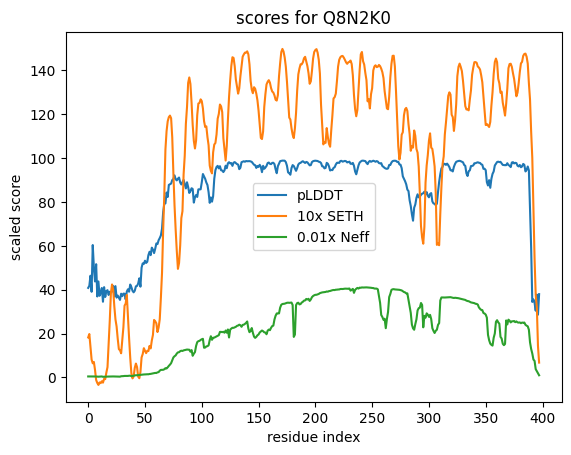

In [63]:
def showscores(protid,sethscale=10.,neffscale=.01):
    plt.plot(plddt[protid],label="pLDDT")
    plt.plot(sethscale*seth[protid],label="%.0fx SETH" % sethscale)
    plt.plot(neffscale*neff[protid],label="%.02fx Neff" % neffscale)
    plt.xlabel("residue index")
    plt.ylabel("scaled score")
    plt.legend()
    plt.title("scores for %s" % protid)
testid = list(ids)[100]
showscores(testid)

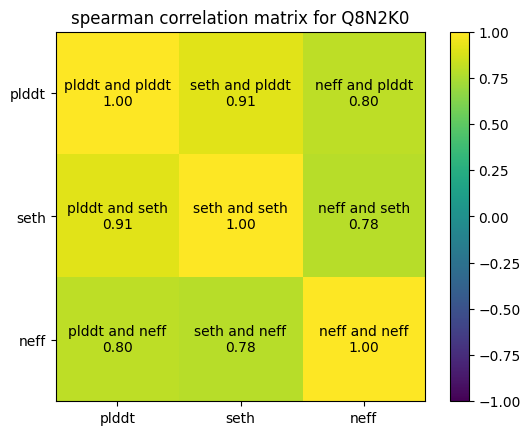

In [64]:
def showcorr(corrmat,name,prefix="",lims=(-1,1)):
    """show correlation between scores"""
    plt.imshow(corrmat)
    plt.colorbar()
    plt.title("%sspearman correlation matrix for %s" % (prefix,name))
    plt.xticks(range(3),scores.keys())
    plt.yticks(range(3),scores.keys())
    if lims is not None:
        plt.clim(*lims)
    for x,l1 in enumerate(scores.keys()):
        for y,l2 in enumerate(scores.keys()):
            val = corrmat[x][y].item()
            plt.text(x,y,"%s and %s\n%.02f" % (l1,l2,val),ha="center",va="center")
showcorr(corrs[testid], name=testid)

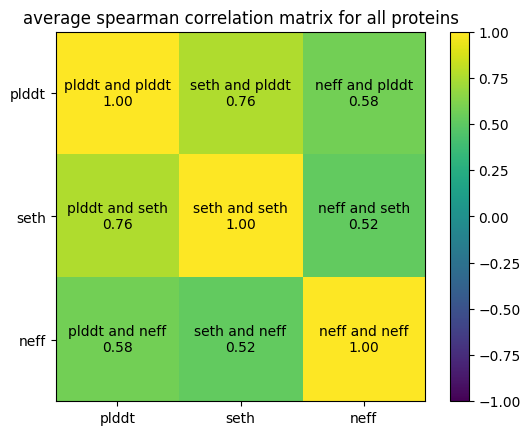

In [72]:
corrstack = torch.stack(tuple(corrs.values()))
corrstd, corravg = torch.std_mean(corrstack,dim=0)
showcorr(corravg, name="all proteins", prefix="average ")

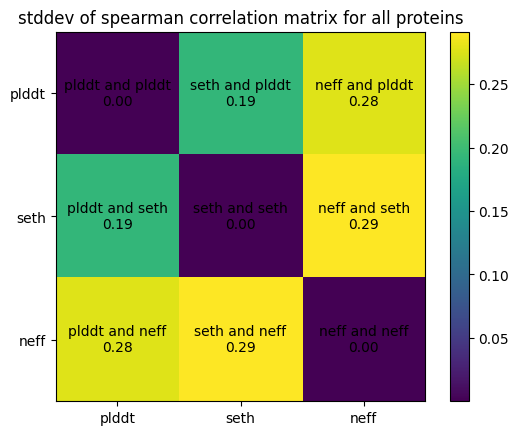

In [66]:
showcorr(corrstd, name="all proteins", prefix="stddev of ", lims=None)

### Find outliers

In [67]:
neffid,plddtid = score2id["neff"],score2id["plddt"]

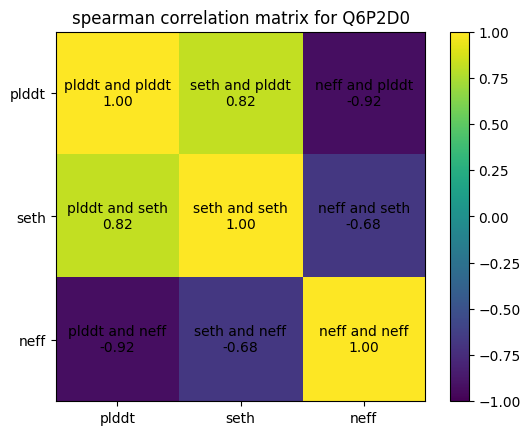

In [68]:
minid,minval = None,float("inf")
for protid in ids:
    val = corrs[protid][neffid,plddtid].item()
    if minval > val:
        minval = val
        minid  = protid
showcorr(corrs[minid],minid)

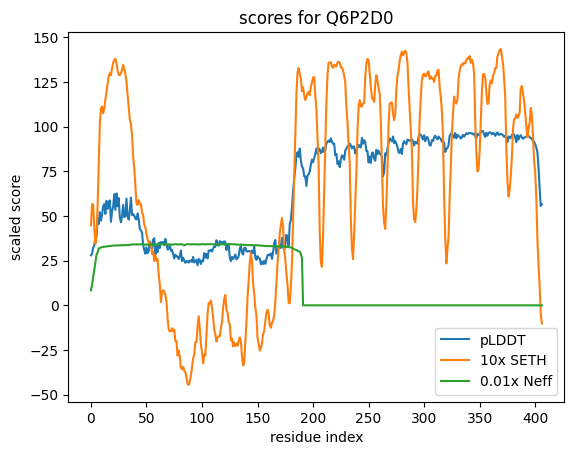

In [69]:
showscores(minid)

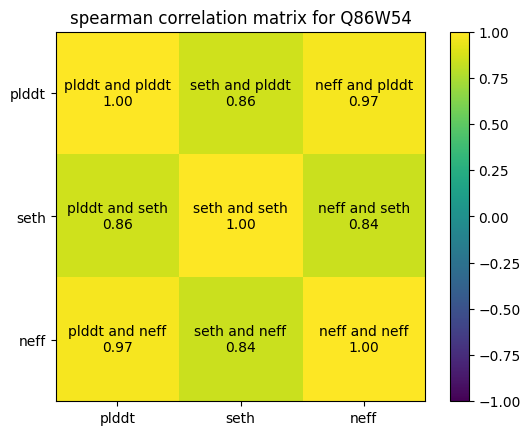

In [70]:
maxid,maxval = None,float("-inf")
for protid in ids:
    val = corrs[protid][neffid,plddtid].item()
    if maxval < val:
        maxval = val
        maxid  = protid
showcorr(corrs[maxid],maxid)

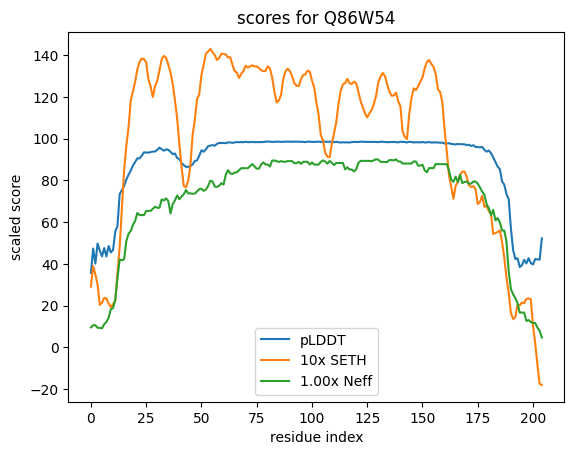

In [71]:
showscores(maxid,neffscale=1)

### Bin scores

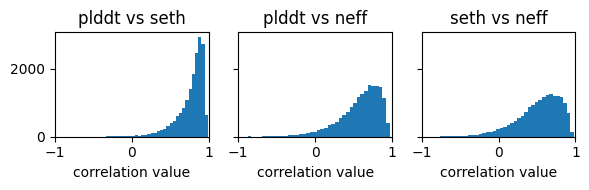

In [198]:
pairs = [("plddt","seth"),("plddt","neff"),("seth","neff")]
idpairs = [(score2id[s1],score2id[s1]) for s1,s2 in pairs]
fig,axs = plt.subplots(ncols=len(pairs),figsize=(6,2),sharey=True)
fig.set_xlabel("# of elems in bin")
for ax,p in zip(axs,pairs):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    
    ax.hist(corrstack[:,id1,id2].sort()[0],bins=40)
    ax.set_title("%s vs %s" % p)
    ax.set_xlabel("correlation value")
    ax.set_xlim(-1,1)
fig.tight_layout()

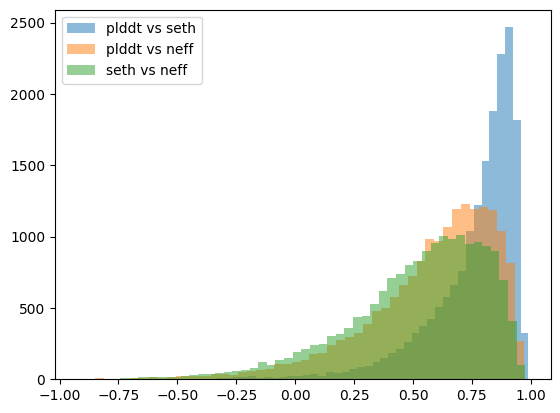

In [196]:
pairs = [("plddt","seth"),("plddt","neff"),("seth","neff")]
for ax,p in zip(axs,pairs):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(corrstack[:,id1,id2].sort()[0],bins=50,label="%s vs %s" % p,alpha=.5)
plt.legend()